# IMDB

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
import pandas as pd

## Preparing the data

In [3]:
path = Path('/local/burghbvander/110kDBRDv2/')
path.ls()

[PosixPath('/local/burghbvander/110kDBRDv2/tmp_lm'),
 PosixPath('/local/burghbvander/110kDBRDv2/test'),
 PosixPath('/local/burghbvander/110kDBRDv2/unsup'),
 PosixPath('/local/burghbvander/110kDBRDv2/tmp_clas_bs96'),
 PosixPath('/local/burghbvander/110kDBRDv2/urls.txt'),
 PosixPath('/local/burghbvander/110kDBRDv2/tmp_clas'),
 PosixPath('/local/burghbvander/110kDBRDv2/train'),
 PosixPath('/local/burghbvander/110kDBRDv2/tmp_clas_bs64'),
 PosixPath('/local/burghbvander/110kDBRDv2/models')]

In [4]:
bs=118

In [5]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .random_split_by_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('tmp_lm')

KeyboardInterrupt: 

In [6]:
data_lm = load_data(path, 'tmp_lm', bs=bs)

In [7]:
data_lm.show_batch()

idx,text
0,"ik uiteindelijk wel zeker , xxmaj matthias was dood . \n xxmaj uit de verschillende verhaallijnen heb ik echter nooit kunnen distilleren wie xxmaj matthias nu wel was . xxmaj wel was het duidelijk dat hij op zijn weg heel wat tegenslagen te verwerken kreeg en niet altijd begrepen werd . \n xxmaj ik kreeg wel een beter beeld van de naasten van xxmaj matthias . \n"
1,/ / xxunk / boeken / girl - online - on - tour / xxbos xxmaj tjonge wat een debuut . xxmaj ik heb van het begin tot het eind genoten . xxmaj schrijf maar lekker door xxmaj elizabeth . u heeft er een fan bij ! \n xxmaj voor mij is dit boek 5 duimpjes waard ! xxbos xxmaj wanneer je ontwikkeling zoekt in een serie dan ben
2,"laten invoelen in de personages zodat je je echt één voelt met ze . xxmaj wat een verschrikkelijke mensen het soms ook zijn . \n xxmaj dit is geen gewone thriller zoals je gewend bent , de spanning en de snelheid zitten er wel degelijk in maar op een totaal andere manier . xxmaj er worden geen mensen vermoord en achtervolgingen gedaan maar er wordt op een rustige intrigerende"
3,"xxmaj angstaanjagend , dat wel . \n \n xxmaj de schrijfstijl van xxmaj lauerhohn is direct , ongenuanceerd en hier en daar zelfs hard , maar dat sluit naadloos aan bij het verhaal . xxmaj de sfeer is benauwend werkelijk , filmisch haast . \n \n “ xxmaj ze stond in een portiek tegenover hun bouwval en xxunk hem . xxmaj het meisje wees met een bevende vinger"
4,"raadselachtige wijze overlijd is het voor de jonge xxmaj michele duidelijk , hij en zijn vader staan lijnrecht tegenover elkaar . \n xxmaj dit deel van het boek vind ik ontzettend spannend en soms ook luguber , maar tegelijkertijd ook moeilijk omdat er veel politiek naar boven komt , en je goed moet opletten hoe de verschillende idealen zich ontwikkelen , en op welke manier deze tegenover elkaar komen"


## Language model

In [7]:
from fastai.text.models import AWD_LSTM

In [8]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=['lm_best', 'itos'], drop_mult=0.3)

In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.75E-02


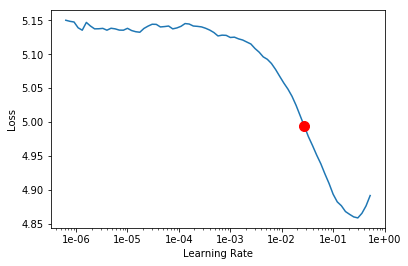

In [11]:
learn.recorder.plot(skip_end=15)

In [12]:
learn.fit_one_cycle(1, 2.75e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.496930,3.367848,0.390874


In [13]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [14]:
learn.unfreeze()

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.92E-06


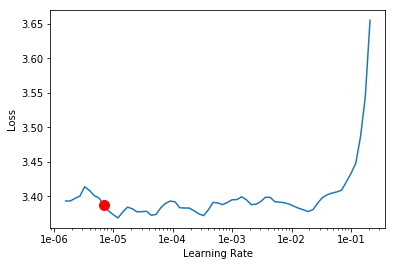

In [16]:
learn.recorder.plot(skip_end=15, skip_start=15)

In [17]:
from fastai.callbacks import SaveModelCallback
cb = SaveModelCallback(learn, every='epoch')

In [18]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7), callbacks=[cb])

epoch,train_loss,valid_loss,accuracy
1,3.186240,3.153318,0.415778
2,3.067432,3.045829,0.429288
3,3.023972,2.990276,0.436462
4,2.955588,2.959568,0.440429
5,2.896513,2.953500,0.441327


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [19]:
learn.save('fine_tuned')

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-04


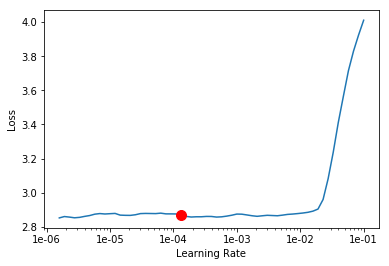

In [22]:
learn.recorder.plot(skip_end=15, skip_start=15)

How good is our model? Well let's try to see what it predicts after a few given words.

In [ ]:
learn.load('fine_tuned');

In [23]:
cb = SaveModelCallback(learn, every='epoch', name='bestmodel_finetune_stage2')

In [24]:
learn.fit_one_cycle(5, 1e-4, moms=(0.8,0.7), callbacks=[cb])

epoch,train_loss,valid_loss,accuracy
1,2.908293,2.953130,0.441311
2,2.908509,2.949950,0.441765
3,2.892625,2.947143,0.442238
4,2.877856,2.945662,0.442433
5,2.890144,2.945429,0.442483


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [25]:
TEXT = "Wat een fantastisch boek"
N_WORDS = 40
N_SENTENCES = 2

In [26]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Wat een fantastisch boek , met een goed verhaal . Een boek waar je in je hoofd mee wilt puzzelen en dan is het ook nog eens spannend . Je krijgt een goed beeld van wat er er allemaal gebeuren is met
Wat een fantastisch boek ! Door de prachtige cover die Jef beschrijft en de prachtige kleuren , die je in zijn greep houdt , is het een boek dat je niet snel zal vergeten . 
  We gaan Wil van


We have to save the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [27]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [9]:
bs=32
fname = 'tmp_clas_bs{}'.format(bs)

In [10]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save(fname)

In [10]:
data_clas = load_data(path, fname, bs=bs)

In [19]:
data_clas.show_batch()

text,target
"xxbos “ xxmaj het huwelijk is het graf van de liefde . ” \n \n xxmaj woorden , woorden , woorden . xxmaj in de juiste volgorde vormen ze een universum waarin je helemaal wil verdwijnen . xxmaj alleen al bij het horen van de naam xxmaj proust word ik – heel toepasselijk - teruggeworpen naar die heerlijke weken waarin ik mocht verdwalen in de omgeving van xxmaj xxunk",neg
"xxbos xxmaj van alle genres die ik lees , ben ik het meest kritisch voor fantasy . xxmaj als fantasy goed is , is hij vaak ook heel goed , maar als een fantasyboek niet echt goed is , wordt het snel kinderachtig . xxmaj nogal wat auteurs ( en lezers ) zijn al tevreden als de obligate tovenaars , draken en magische zwaarden aanwezig zijn . xxmaj het verhaal",neg
"xxbos xxmaj het is zo treurig dat in het tijdperk waarin iedereen ( in de vrije wereld althans ) uitstekend xxunk is om de juistheid of xxunk van elke stelling , elke bewering zelf na te gaan , vrijwel niemand de moeite neemt om het te doen . xxmaj het kritisch vermogen ontbreekt kennelijk volkomen . xxmaj een paar xxunk en je duikt in gedigitaliseerde archieven , bekijkt ebook versies",neg
"xxbos xxmaj de jonge filosoof xxmaj ype de xxmaj boer ( 1989 ) , die gepromoveerd is op de postmoderne xxmaj italiaanse filosoof xxmaj xxunk , heeft onlangs een boekje gepubliceerd waarin hij xxmaj murakami 's fictie interpreteert vanuit filosofische invalshoek . xxmaj wat zijn de kernthema 's van xxmaj murakami 's fictie , zo vraagt xxmaj de xxmaj boer zich af , en wat voor waardevolle filosofische conclusies kunnen",pos
"xxbos xxmaj pierre xxmaj lauffer ( 1920 - 1981 ) schreef vrijwel zijn hele leven poëzie en proza . xxmaj frank xxmaj martinus xxmaj arion noemde hem de xxmaj dante van het xxmaj papiaments . ‘ xxmaj je kunt zeggen dat iedereen die in het xxmaj papiaments goede poëzie schrijft , op de ene of andere manier door xxmaj pierre beïnvloed is.’ xxmaj helaas was het juist de taal die",pos


We can then create a model to classify those reviews and load the encoder we saved before.

In [11]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-02


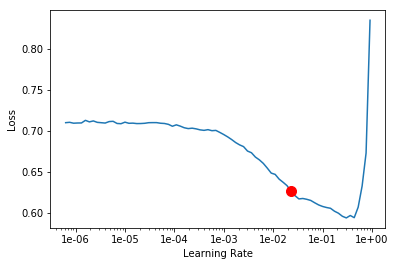

In [32]:
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.458731,0.320228,0.860554


In [34]:
learn.save('first')

In [ ]:
learn.load('first');

In [35]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.304465,0.214348,0.915950


In [36]:
learn.save('second')

In [14]:
learn.load('second');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06


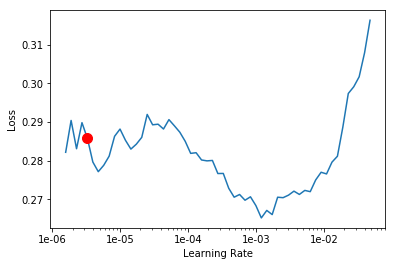

In [15]:
learn.lr_find()
learn.recorder.plot(skip_end=15, skip_start=15)

In [16]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-5/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.278979,0.195604,0.922159


In [17]:
learn.save('third')

In [12]:
learn.load('third');

In [13]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.268836,0.191526,0.927889
2,0.238436,0.176344,0.931710


In [14]:
learn.save('fourth')

In [15]:
# Model seems not to overfit yet! Try again with more epochs
learn.load('third');
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.286334,0.188037,0.926457
2,0.267689,0.176839,0.930277
3,0.261010,0.171448,0.934097
4,0.224315,0.171247,0.934575
5,0.227327,0.163605,0.938395


In [16]:
learn.save('fifth')

In [17]:
learn.show_results(rows=10)

text,target,prediction
"xxbos xxmaj grieks drama in de xxunk \n \n \n xxmaj xxunk : spoilers \n \n \n ‘ xxmaj de volle maan , tragisch die avond , was reeds vroeg , nog in de laatste xxunk xxunk als een immense , xxunk bol , xxunk als een zonsondergang laag achter de xxunk van de xxmaj lange xxmaj laan en steeg , langzaam zich louterende van haar tragische tint",pos,pos
"xxbos xxmaj for xxunk : xxmaj below \n \n xxmaj deon xxmaj meyer is een van mijn favoriete schrijvers . xxmaj op 9 juni zou xxmaj deon zijn boeken signeren in een boekhandel van xxunk , slechts 35 km van mijn dorpje . xxmaj nou ben ik niet iemand , die snel contact maakt met allerlei schrijvers , maar als het zo dichtbij is , kon ik dit niet",pos,pos
xxbos xxmaj giorgio xxmaj bassani ( 1916 - 2000 ) heeft tot 1981 een groot deel van leven doorgebracht in een xxmaj joodse gemeenschap in het xxmaj noord - xxmaj italiaanse stadje xxmaj ferrara aan de rivier de xxmaj po . xxmaj hij wordt gezien als een van de belangrijkste moderne schrijvers van xxmaj italië . \n \n xxmaj de kronieken van xxmaj ferrara ( xxmaj il xxmaj xxunk,pos,pos
"xxbos xxmaj ondanks zijn grote succes als dichter en een boekenplank vol publicaties vecht xxmaj rogi xxmaj wieg ( 1962 ) al jarenlang tegen zijn depressies . xxmaj misschien heeft het een met het ander te maken . xxmaj iemand die zo diep durft te gaan in wat hij schrijft , iemand die pijnlijk eerlijk over zichzelf durft te zijn , zoals in xxmaj kameraad xxmaj scheermes , zet zichzelf",pos,pos
"xxbos xxmaj maar de kerel staat erop . “ xxmaj in dit land , ” verklaart hij , “ moet je , als je iets wilt hebben , dwang xxunk \n \n ( … ) \n \n ‘ “ xxmaj er zitten twee mensen in een kamer , ” begin ik . “ xxmaj ineens wordt er aan de deur xxunk \n \n xxmaj bij dit eerste",pos,pos
"xxbos xxmaj hoewel dit boek de xxmaj man xxmaj booker prijs 2014 gewonnen heeft zijn de meningen verdeeld : sommigen vinden het een meesterwerk , terwijl bijvoorbeeld de xxmaj new xxmaj york xxmaj times sprak van een "" deeply xxunk novel "" . xxmaj zelf baalde ik als een stekker dat dit boek won terwijl prachtboeken van andere giganten ( xxmaj mitchell , xxmaj powers , xxmaj amis ) niet",pos,pos
"xxbos xxmaj achterflap : \n xxmaj ruim zeventig jaar nadat een xxmaj duitse xxunk zijn geheime “ xxmaj wunderwaffen ” van de brandstapel wist te redden , vindt er in het grensgebied van xxmaj soedan een mysterieuze explosie plaats , waardoor de bevolking van een compleet dorp van de aardbodem verdwijnt . xxmaj als het bericht van de slachting xxmaj europa bereikt , wordt xxmaj alex xxmaj de xxmaj",pos,pos
"xxbos xxmaj het leven is hardlopen , onder andere xxrep 5 . \n \n \n \n ‘ xxmaj ik hou er niet van om te veel over mezelf te vertellen , maar als ik anderzijds niet eerlijk vertel wat er te vertellen valt , heeft het schrijven van een boek als dit niet veel zin en had ik me net zo goed de moeite kunnen besparen [ xxrep 4",pos,neg
"xxbos xxmaj toen ik de voorpublicatie van dit boek van xxmaj giphart gelezen had , was ik direct gegrepen en ben ik zeer enthousiast geworden om mee te doen aan de xxmaj hebban - leesclub . xxmaj ik moet eerlijk zeggen - en ik heb dat ook eerlijk gezegd in mijn motivatie voor de leesclub - dat ik maar één boek van xxmaj giphart gelezen heb : xxmaj troost uit",neg,neg
"xxbos ‘ xxmaj villa xxmaj toscane – xxmaj linda xxmaj van xxmaj xxunk – xxmaj een trage start met een voorspelbaar einde . \n \n “ xxmaj villa xxmaj toscane ” , een titel waarmee je als lezer meteen in vakantiestemming terechtkomt , maar al snel blijkt het toch niet de beste bestemming te zijn en al zeker niet met het verleden van xxmaj carlo en zijn ex -",neg,neg


In [18]:
interp = learn.interpret()

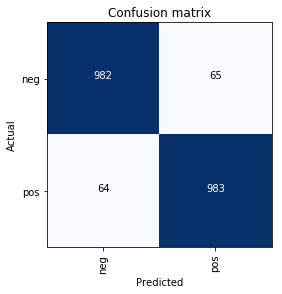

In [19]:
interp.plot_confusion_matrix()

In [20]:
interp.top_losses(k=10)

(tensor([9.5704, 7.3124, 5.9622, 5.8540, 5.8231, 4.8916, 4.7085, 3.7781, 3.5620,
         3.4087]),
 tensor([2060, 2032, 1402, 1002, 1813, 1274,  418,  380,  178, 1853]))

In [21]:
learn.data.valid_ds[2060]

(Text xxbos xxmaj met haar debuut xxmaj muidhond heeft xxmaj inge xxmaj schilperoord een gevoelig onderwerp in de literatuur aangesneden . 
  
   xxmaj muidhond gaat over xxmaj jonathan ( 30 ) die na vrijspraak bij gebrek aan bewijs terugkeert naar huis . xxmaj hij woont samen met zijn moeder in een vissersdorpje en werkt in een xxunk . xxmaj hij heeft zijn hond xxmaj milk gemist en is blij dat hij weer met zijn hond door de duinen kan wandelen . xxmaj daar vind hij in een klein meertje een muidhond die hij mee naar huis neemt om voor te zorgen . xxmaj hij wordt rustig van het kijken naar de vis in zijn aquarium . 
  
   xxmaj jonathan is een pedofiel die na zijn vrijspraak probeert om een ‘ nieuw mens’ te worden . xxmaj hij stelt een strak xxunk op en verplicht zichzelf aan opdrachten te werken die hij van zijn psycholoog heeft meegekregen . xxmaj dan leert hij een nieuw buurmeisje ( xxmaj elke ) kennen en wordt zijn voornemen zwaar op de proef gesteld . xxmaj om deze worsteling met z

In [22]:
y_probs, y_pred, y_loss = learn.get_preds(ordered=True, with_loss=True)

In [23]:
y_probs[2060], y_pred[2060], y_loss[2060]

(tensor([0.0586, 0.9414]), tensor(1), tensor(9.5704))